# Training and evaluation of a neural network

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

## Define the network architecture

### Define the neural network

In [13]:
def convert_to_tensor(data: DataFrame):   
    inputs = torch.tensor(data.drop("emotion", axis=1).to_numpy(dtype=np.float32))
    index2label = [label for label in data["emotion"].unique()]
    label2index = {label: index for index, label in enumerate(index2label)}
    labels = torch.tensor([label2index[label] for label in data["emotion"]], dtype=torch.long)
    return list(zip(inputs, labels))

In [14]:
class EmotionClassifierNN(nn.Module):
    def __init__(self, n_features:int = 20, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(n_features, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 4)
        )
    
    def forward(self, input):
        return self.net(input)

### Train the neural network

In [15]:
def train_nn(train_df: DataFrame, epochs: int = 100, batch_size: int = 256, learning_rate: float = 0.5, with_pca: bool = True) -> EmotionClassifierNN:    
    nn_model = EmotionClassifierNN(len(train_df.columns) - 1)

    train_data = convert_to_tensor(train_df)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)

    losses_per_epoch = []
    acc_per_epoch = []
    for epoch in range(epochs):
        losses = []
        correct_preds = 0
        for inputs, labels in train_loader:
            output = nn_model(inputs)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            correct_preds += torch.sum(torch.argmax(output, dim=1) == labels)
            losses.append(loss.item())
        print(f"Epoch {epoch+1}: loss: {np.mean(losses)}, accuracy: {correct_preds / len(train_data)}")
        acc_per_epoch.append(correct_preds / len(train_data))
        losses_per_epoch.append(np.mean(losses))

    plt.plot(range(epochs), losses_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if with_pca:
        plt.title("Loss per epoch with PCA")
    else:
        plt.title("Loss per epoch without PCA")
    plt.show()

    plt.plot(range(epochs), acc_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    if with_pca:
        plt.title("Accuracy per epoch with PCA")
    else:
        plt.title("Accuracy per epoch without PCA")
    plt.show()

    return nn_model

### Evaluate the neural network

In [16]:
def evaluate_nn(nn_model: EmotionClassifierNN, train_df: DataFrame, test_df: DataFrame):   
    train_data = convert_to_tensor(train_df)
    test_data = convert_to_tensor(test_df)

    emotions = [label for label in train_df["emotion"].unique()]

    correct_pred_train = {emotion: 0 for emotion in emotions}
    total_pred_train = {emotion: 0 for emotion in emotions}
    correct_pred_test = {emotion: 0 for emotion in emotions}
    total_pred_test = {emotion: 0 for emotion in emotions}

    with torch.no_grad():
        for inputs, labels in train_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_train[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_train[emotions[labels]] += 1

    with torch.no_grad():
        for inputs, labels in test_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_test[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_test[emotions[labels]] += 1

    for emotion in emotions:
        # Calculate the train and test data accuracy for the current emotion
        train_accuracy = correct_pred_train[emotion] / total_pred_train[emotion]
        test_accuracy = correct_pred_test[emotion] / total_pred_test[emotion]

        # Print the accuracies with improved formatting
        print(f"Accuracy for {emotion}:")
        print(f"\tTrain data: {train_accuracy:.2f}")
        print(f"\tTest data: {test_accuracy:.2f}")

    # Calculate the total train and test data accuracy
    total_train_accuracy = sum(correct_pred_train.values()) / sum(total_pred_train.values())
    total_test_accuracy = sum(correct_pred_test.values()) / sum(total_pred_test.values())

    # Print the total accuracies with improved formatting
    print("Total accuracy:")
    print(f"\tTrain data: {total_train_accuracy:.2f}")
    print(f"\tTest data: {total_test_accuracy:.2f}")

## Handle the dataset with pca

In [17]:
train_df_w_pca = pd.read_csv("train.csv")
test_df_w_pca = pd.read_csv("test.csv")

Epoch 1: loss: 1.32448190764377, accuracy: 0.36765336990356445
Epoch 2: loss: 1.0885994246131496, accuracy: 0.5467610359191895
Epoch 3: loss: 1.0259862102960284, accuracy: 0.5583440661430359
Epoch 4: loss: 1.0016656486611617, accuracy: 0.5810810923576355
Epoch 5: loss: 0.9938826247265464, accuracy: 0.5864436030387878
Epoch 6: loss: 0.9734385703739367, accuracy: 0.5926640629768372
Epoch 7: loss: 0.9733989144626417, accuracy: 0.5922350883483887
Epoch 8: loss: 0.9726868711019817, accuracy: 0.5939511060714722
Epoch 9: loss: 0.9620459205225894, accuracy: 0.5939511060714722
Epoch 10: loss: 0.9664175667260823, accuracy: 0.5971686244010925
Epoch 11: loss: 0.9697571710536355, accuracy: 0.5986701250076294
Epoch 12: loss: 0.9526313857028359, accuracy: 0.6044616103172302
Epoch 13: loss: 0.9550109380169919, accuracy: 0.6055340766906738
Epoch 14: loss: 0.9613255231004012, accuracy: 0.5993136167526245
Epoch 15: loss: 0.9476135184890345, accuracy: 0.607464611530304
Epoch 16: loss: 0.9478322361644945, 

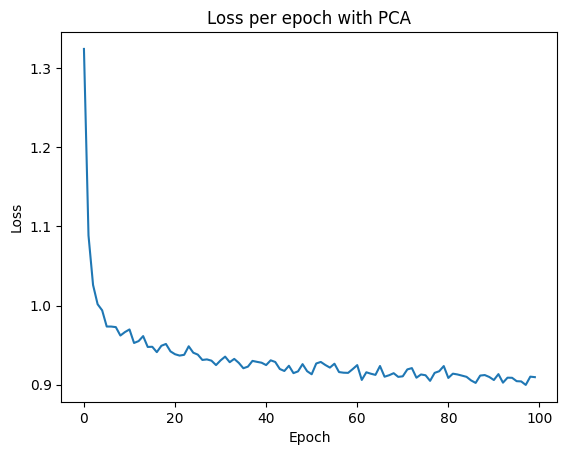

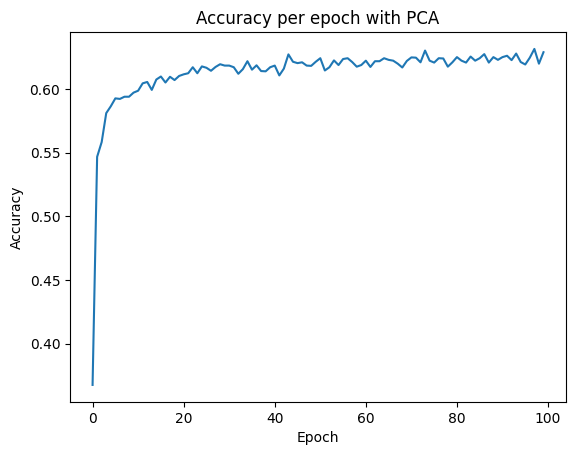

In [18]:
nn_model = train_nn(train_df_w_pca, epochs=100, batch_size=256, learning_rate=0.5, with_pca=True)

In [19]:
evaluate_nn(nn_model, train_df_w_pca, test_df_w_pca)

Accuracy for happy:
	Train data: 0.89
	Test data: 0.87
Accuracy for neutral:
	Train data: 0.70
	Test data: 0.29
Accuracy for angry:
	Train data: 0.38
	Test data: 0.10
Accuracy for sad:
	Train data: 0.22
	Test data: 0.22
Total accuracy:
	Train data: 0.62
	Test data: 0.43


## Handle the dataset without pca

In [20]:
train_df_wo_pca = pd.read_csv("train_wo_pca.csv")
test_df_wo_pca = pd.read_csv("test_wo_pca.csv")

Epoch 1: loss: 1.3335734166597064, accuracy: 0.3436293303966522
Epoch 2: loss: 1.1288152086107355, accuracy: 0.5171599984169006
Epoch 3: loss: 1.0520194016004865, accuracy: 0.5489060282707214
Epoch 4: loss: 1.034110100645768, accuracy: 0.5579150319099426
Epoch 5: loss: 1.0072078422496193, accuracy: 0.5662805438041687
Epoch 6: loss: 1.0049986902036165, accuracy: 0.57722008228302
Epoch 7: loss: 0.9858118672119943, accuracy: 0.5873016119003296
Epoch 8: loss: 0.97386697405263, accuracy: 0.5952380895614624
Epoch 9: loss: 0.9566097165408888, accuracy: 0.5982410907745361
Epoch 10: loss: 0.9581698492953652, accuracy: 0.5986701250076294
Epoch 11: loss: 0.9473855495452881, accuracy: 0.5971686244010925
Epoch 12: loss: 0.9529967245302702, accuracy: 0.6046761274337769
Epoch 13: loss: 0.9374745613650272, accuracy: 0.6072500944137573
Epoch 14: loss: 0.9478102985181307, accuracy: 0.6012440919876099
Epoch 15: loss: 0.9504326330988031, accuracy: 0.6098241209983826
Epoch 16: loss: 0.9256918838149623, acc

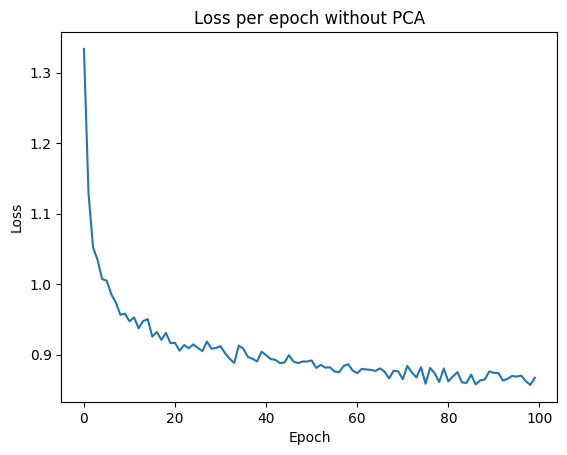

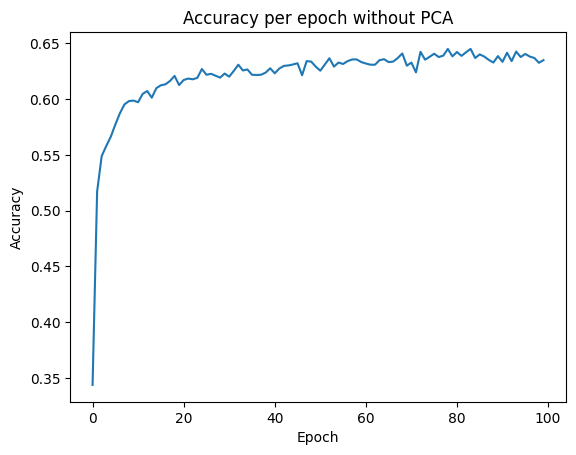

In [21]:
nn_model = train_nn(train_df_wo_pca, epochs=100, batch_size=256, learning_rate=0.5, with_pca=False)

In [22]:
evaluate_nn(nn_model, train_df_wo_pca, test_df_wo_pca)

Accuracy for happy:
	Train data: 0.85
	Test data: 0.87
Accuracy for neutral:
	Train data: 0.75
	Test data: 0.40
Accuracy for angry:
	Train data: 0.38
	Test data: 0.03
Accuracy for sad:
	Train data: 0.32
	Test data: 0.33
Total accuracy:
	Train data: 0.64
	Test data: 0.45
